In [2]:
#imports
import numpy as np
import numpy.random as rd
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from hmmlearn import hmm

In [3]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1
    return 0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def steady_state_prob(matrix):
    """
    This function calculates relative throughput from a probability matrix
    :param matrix: the probability matrix
    :return: A list of relative throughput values
    """
    a_list = []
    b_list = []
    for v in matrix:
        a_list.append(1)
        b_list.append(0)
    b_list.append(1)
    A = np.append(np.transpose(matrix) - np.identity(len(matrix)), [a_list], axis=0)
    b = np.transpose(np.array(b_list))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

In [4]:
en = 3
ch = 3
tol = 0.25
P = np.array([[.1, .2, .7],[.5, .3, .2],[.3, .3, .4]])
E = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
# E = np.array([[.6,.9,.3],[.3,.5,.1],[.4,.1,.05]])
# P = row_normalize(np.random.rand(ch,ch))
# E = np.random.rand(ch,ch)
rate = np.array([8.,4.,6.])
lr = 0.01
eps = 1.0
eps_min = 0.05
print(P)
print(E)

[[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]


In [5]:
lamda = [np.ones(en)/en]
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))
chnl = []; b = [] ; enc = []
emp_rate = [0]; emp_err = [0]
chnl.append(rd.randint(0,ch-1))
enc.append(rd.randint(0,en-1))
b.append(0)
step = 10
t = 0

In [6]:
T = 10000
sprob = steady_state_prob(p[-1])
r = rd.rand()
while t < T:
    if r < max(eps_min,eps/float(t+1)): # put as running eps
        enc.append(rd.randint(0,en))
    else:
        enc.append(sample(lamda[-1]))
    chnl.append(sample(P[chnl[-1]]))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    if (t+1)%step == 0:
        model = hmm.MultinomialHMM(n_components=ch, params='t', init_params='',n_iter=100, tol=1.0e-2)
        model.startprob_ = sprob
        if r < max(eps_min,eps/float(t+1)):
            step_emiss = np.sum(E,axis=0)/3
        else:
            step_emiss = np.sum(np.transpose([lamda[-1]])*E,axis=0)
        model.emissionprob_ = [[step_emiss[i],1-step_emiss[i]] for i in range(ch)]
        model.transmat_ = np.copy(p[-1])
        model.fit([b[-1*step:]])
        temp = np.copy(p[-1])
        lr = min(lr,1.0/float(t+1)) # adaptive learning rate
        temp = temp + lr*(model.transmat_-temp) # progressive update
        temp = row_normalize(temp)
        p.append(temp)
        sprob = steady_state_prob(p[-1])
        ub = np.sum(E*sprob,axis=1)
        ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-2})
        lamda.append(ltemp.x)
        r = rd.rand()
        emp_err.append(np.dot(ltemp.x,ub))
        emp_rate.append(np.dot(ltemp.x,rate))
        print(t,emp_rate[-1],ltemp.success,lr,)
    t+=1

9 4.666072240957595 True 0.01
19 4.678647141310794 True 0.01
29 4.677150067462307 True 0.01
39 4.685627560758913 True 0.01
49 4.680094776947101 True 0.01
59 4.688484666148415 True 0.01
69 4.687885685124031 True 0.01
79 4.6917326658901235 True 0.01
89 4.683730098094426 True 0.01
99 4.683995034353609 True 0.01
109 4.69514009697734 True 0.00909090909090909
119 4.705280984065146 True 0.008333333333333333
129 4.698107971536855 True 0.007692307692307693
139 4.6891941877986945 True 0.007142857142857143
149 4.687482997071568 True 0.006666666666666667
159 4.687641348147254 True 0.00625
169 4.692548840183241 True 0.0058823529411764705
179 4.6915514538196135 True 0.005555555555555556
189 4.691684863043017 True 0.005263157894736842
199 4.697771271667815 True 0.005
209 4.70069294353026 True 0.004761904761904762
219 4.7008143375897795 True 0.004545454545454545
229 4.70441827536523 True 0.004347826086956522
239 4.707869818976897 True 0.004166666666666667
249 4.711175421615101 True 0.004
259 4.7103099

In [7]:
# print(p[0])
print('estimated trans\n',p[-1])
print('real trans\n',P)
print('lamda\n',lamda[-1])
# print(sprob)
# print(model.transmat_)

estimated trans
 [[0.28156575 0.32978671 0.38864755]
 [0.28392136 0.31829928 0.39777937]
 [0.28333469 0.33310387 0.38356144]]
real trans
 [[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
lamda
 [0.18744518 0.81255482 0.        ]


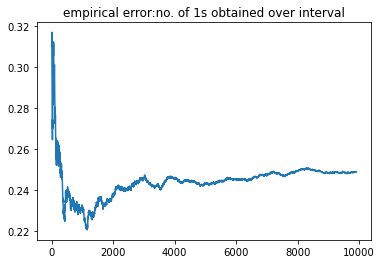

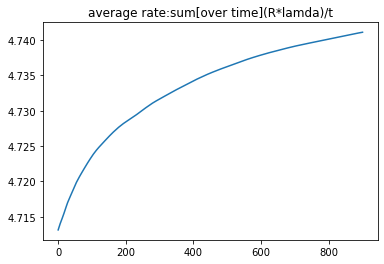

In [8]:
stat = 100
error_plot = 1.0 - np.copy(b)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('empirical error:no. of 1s obtained over interval')
plt.show()
rate_plot = np.copy(emp_rate)
for i in range(1,len(rate_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

In [9]:
print(rate_plot[-1],error_plot[-1])

4.741117756403363 0.2488


16.14298622234589


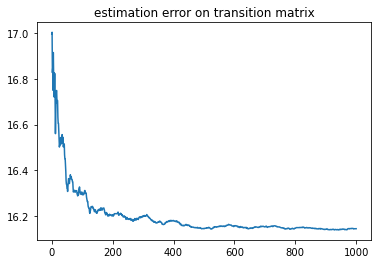

In [10]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in p:
    err.append(np.sqrt(np.sum(np.square(P-i))/s)*100)
print(err[-1])
plt.plot(err)
plt.title('estimation error on transition matrix')
plt.show()

0.18360655737704915
4.885245901639345 1.0 [0.] True 0.25
4.801800000000011


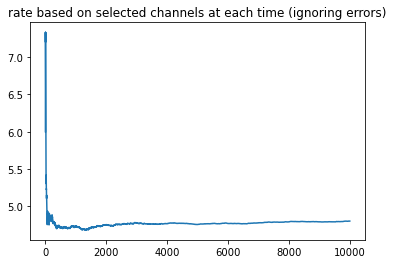

In [11]:
ub = np.sum(E*steady_state_prob(P),axis=1)
ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(min(ub))
print(np.dot(ltemp.x,rate), np.sum(ltemp.x),ltemp.con, ltemp.success, np.dot(ltemp.x,ub))
rate_plot = [0]
for i in range(1,len(enc)):
    rate_plot.append((rate_plot[i-1]*(i-1))+rate[enc[i]])
    rate_plot[i] =rate_plot[i]/i
print(rate_plot[-1])
plt.plot(rate_plot[1:])
plt.title('rate based on selected channels at each time (ignoring errors)')
plt.show()

[0.28302606 0.3273192  0.38965474]
[0.29508197 0.2704918  0.43442623]
4.234455443445735


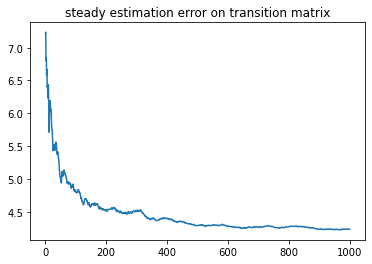

In [12]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in p:
    err.append(np.sqrt(np.sum(np.square(steady_state_prob(P)-steady_state_prob(i)))/3)*100)
print(steady_state_prob(p[-1]))
print(steady_state_prob(P))
print(err[-1])
plt.plot(err)
plt.title('steady estimation error on transition matrix')
plt.show() 

In [79]:
T = 10000
chnl = [0];enc = [1];b = [0]
t = 0
while t < T:
    enc.append(1)
    chnl.append(sample(P[chnl[-1]]))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    t+=1

In [80]:
# reference
model = hmm.MultinomialHMM(n_components=3, algorithm='viterbi', params='t', init_params='t',n_iter=100, tol=1.0e-2)
model.emissionprob_ = [[E[1][0],1.0-E[1][0]],[E[1][1],1.0-E[1][1]],[E[1][2],1.0-E[1][2]]]
model.startprob_ = np.ones(ch)/ch
model.fit([b])
# print(model.emissionprob_,model.startprob_)
print(model.transmat_,P)
s = np.shape(P)[0]*np.shape(P)[1]
print('Error',np.sqrt(np.sum(np.square(P-model.transmat_))/s)*100)

[[0.32648973 0.25455309 0.41895717]
 [0.32324151 0.23802305 0.43873544]
 [0.32905633 0.27133042 0.39961325]] [[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
Error 15.881659386408442
